# Kaggle - Digit Recognizer (MNIST)

### 사용 라이브러리

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data Load

In [7]:
train, test = pd.read_csv("./digit-recognizer/train.csv"), pd.read_csv("./digit-recognizer/test.csv")

train.shape, test.shape

((42000, 785), (28000, 784))

In [8]:
display(train.head())
display(test.head())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`0~9`까지 손으로 쓴 정수 이미지 데이터라 픽셀이 들어있음

In [9]:
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)
del train

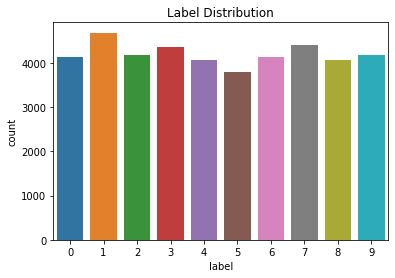

In [14]:
_ = sns.countplot(x=Y_train).set_title("Label Distribution")

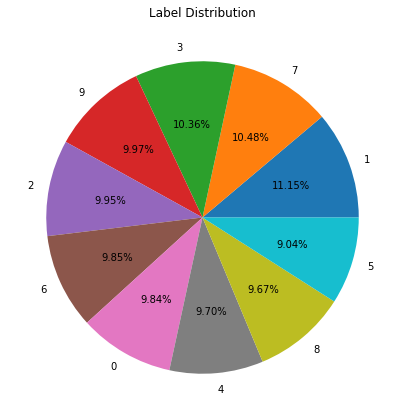

In [27]:
plt.figure(figsize=(7,10))
_ = plt.pie(Y_train.value_counts().values, labels=Y_train.value_counts().index, autopct="%.2f%%")
plt.title("Label Distribution")
plt.show()

### 결측치 확인

In [29]:
X_train.isnull().sum().sum()

0

In [32]:
test.isnull().sum().sum()

0

### 정규화

In [39]:
X_train = X_train / 255.0
test = test / 255.0

### Reshape

In [40]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

### Encoding

In [42]:
Y_train = to_categorical(Y_train, num_classes=10)

### 데이터 나누기

In [43]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15, stratify=Y_train)

print(f"x_train: {x_train.shape}\ny_train: {y_train.shape}\nx_val: {x_val.shape}\ny_val: {y_val.shape}")

x_train: (35700, 28, 28, 1)
y_train: (35700, 10)
x_val: (6300, 28, 28, 1)
y_val: (6300, 10)


### 예시 이미지 출력

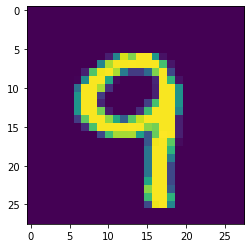

In [64]:
_ = plt.imshow(x_train[0][:, :, 0])

## CNN Model

In [66]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(10, activation="softmax"))

In [68]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

`RMSprop`는 `Root Mean Square Propagation`의 약자임  
`rho`는 그라디언트의 예정된 감소 계수  
`epsilon`는 수치 안정성을 위한 상수  
`decay`는 업데이트마다 적용되는 학습률의 감소율을 의미

In [69]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)

## 데이터 증강 (Data Augmentation)

In [71]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Train

In [72]:
with tf.device("/device:GPU:0"):
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=86), epochs=30, validation_data=(x_val, y_val),
                                  verbose=2, steps_per_epoch=x_train.shape[0]//86, callbacks=[early_stopping])

Epoch 1/30
415/415 - 12s - loss: 0.4318 - accuracy: 0.8606 - val_loss: 0.0998 - val_accuracy: 0.9686
Epoch 2/30
415/415 - 6s - loss: 0.1322 - accuracy: 0.9609 - val_loss: 0.0426 - val_accuracy: 0.9870
Epoch 3/30
415/415 - 6s - loss: 0.0961 - accuracy: 0.9706 - val_loss: 0.0315 - val_accuracy: 0.9906
Epoch 4/30
415/415 - 6s - loss: 0.0752 - accuracy: 0.9767 - val_loss: 0.0324 - val_accuracy: 0.9922
Epoch 5/30
415/415 - 6s - loss: 0.0720 - accuracy: 0.9793 - val_loss: 0.0373 - val_accuracy: 0.9913
Epoch 6/30
415/415 - 6s - loss: 0.0634 - accuracy: 0.9815 - val_loss: 0.0351 - val_accuracy: 0.9906
Epoch 7/30
415/415 - 6s - loss: 0.0592 - accuracy: 0.9828 - val_loss: 0.0382 - val_accuracy: 0.9919


## 모델 평가

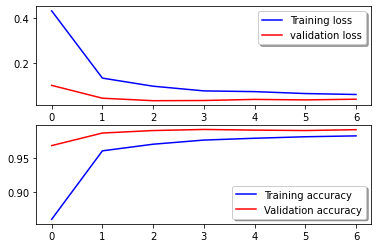

In [77]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [78]:
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = np.argmax(y_val, axis=1)

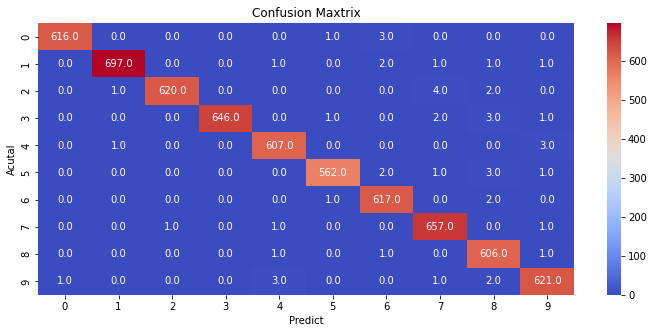

In [90]:
plt.figure(figsize=(12, 5))
_ = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Confusion Maxtrix")
plt.xlabel("Predict")
plt.ylabel("Acutal")
plt.show()

## Submit

In [93]:
result = model.predict(test)
result = pd.Series(np.argmax(result, axis=1))

In [98]:
sub = pd.read_csv("./digit-recognizer/sample_submission.csv")
sub["Label"] = result
sub.to_csv("./digit-recognizer/sub_acc_9828.csv", index=False)